In [2]:
# Imports
library(Seurat)
library(SingleCellExperiment)
library(SingleR)
library(celldex)    
library(ggplot2)
library(clustree)
library(stringr) 
library(gridExtra)
library(scDblFinder)

# Change setting for visualizing plots within VSCODE
options(repr.plot.width=20, repr.plot.height=12)

Warning message:
"package 'Seurat' was built under R version 4.4.2"
Loading required package: SeuratObject

Warning message:
"package 'SeuratObject' was built under R version 4.4.2"
Loading required package: sp

Warning message:
"package 'sp' was built under R version 4.4.2"

Attaching package: 'SeuratObject'


The following objects are masked from 'package:base':

    intersect, t


Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats

Warning message:
"package 'matrixStats' was built under R version 4.4.2"

Attaching package: 'MatrixGenerics'


The following objects are masked from 'package:matrixStats':

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, 

In [3]:
# Function to use ScDblFinder to find doublets
remove_seurat_doublets <- function(seurat_object) {
    # To be able to use ScDBIFinder, we need to convert it to SCE
    sce_object <- as.SingleCellExperiment(seurat_object)
    
    # Run scDblFinder function
    sce_object <- scDblFinder(sce_object)

    # View table
    table(sce_object$scDblFinder.class)

    # as.Seurat needs logcounts but we dont want to calculate log counts, to trick we assume sce logcounts = counts
    logcounts(sce_object) <- assay(sce_object, "counts")

    # Convert SCE object back to Seurat
    seurat_object <- as.Seurat(sce_object)
    seurat_object <- subset(seurat_object, subset = scDblFinder.class == "singlet")
    seurat_object[["RNA"]] <- as(seurat_object[["RNA"]], "Assay5")
    return(seurat_object)
}

In [8]:
# Set wd
setwd("../../../Data/Winkels et al. (2020)")
list.files()
getwd()

# Read in data
WD_20 <- Read10X(data.dir = "WD")
CD_20 <- Read10X(data.dir = "CD")
CD_8 <- Read10X(data.dir = "Baseline")

# Create Seurat obj
WD20_obj <- CreateSeuratObject(WD_20, project="WD 20") # WD 20 weken
CD20_obj <- CreateSeuratObject(CD_20, project="CD 20") # Chow 20 weken
CD8_obj <- CreateSeuratObject(CD_8, project="CD 8") # Chow 8 weken

# Remove doublets from individual samples
# To add reproducability in the future, consider adding BPARAM = bp, where bp = Multicore(n, seed)
WD_20obj <- remove_seurat_doublets(WD20_obj)
CD_20obj <- remove_seurat_doublets(CD20_obj)
CD_8obj <- remove_seurat_doublets(CD8_obj)

WD_20obj@assays

# Merge the Seurat objects
sc.data <- merge(WD_20obj, y=list(CD_20obj, CD_8obj),
                    add.cell.ids = c("WD20", "CD20", "CD8"),
                    project="Merged version of WD20, CD20 and CD8")

# Merge layers
sc.data[["RNA"]] <- JoinLayers(sc.data[["RNA"]])

[1] "Baseline"                          "CD"                               
[3] "WD"                                "Winkels_macrophages_annotated.rds"
[5] "Winkels_raw.rds"                   "Winkels_raw_modified_orig.rds"

[1] "c:/Users/phili/Desktop/BMW Jaar 3/Afstudeerscriptie/project_scriptie/Data/Winkels et al. (2020)"

Warning message:
"Layer 'data' is empty"
Warning message:
"Layer 'scale.data' is empty"
Creating ~1662 artificial doublets...

Dimensional reduction

Evaluating kNN...

Training model...

iter=0, 245 cells excluded from training.

iter=1, 245 cells excluded from training.

iter=2, 263 cells excluded from training.

Threshold found:0.903

108 (5.2%) doublets called

Warning message:
"Assay RNA changing from Assay to Assay5"
Warning message:
"Layer 'data' is empty"
Warning message:
"Layer 'scale.data' is empty"
Creating ~1500 artificial doublets...

Dimensional reduction

Evaluating kNN...

Training model...

iter=0, 92 cells excluded from training.

iter=1, 98 cells excluded from training.

iter=2, 95 cells excluded from training.

Threshold found:0.831

46 (5.1%) doublets called

Warning message:
"Assay RNA changing from Assay to Assay5"
Warning message:
"Layer 'data' is empty"
Warning message:
"Layer 'scale.data' is empty"
Creating ~1500 artificial doublets...

Dimensional reduction



$RNA
Assay (v5) data with 27998 features for 1969 cells
First 10 features:
 XKR4, GM1992, GM37381, RP1, RP1.1, SOX17, GM37323, MRPL15, LYPLA1,
GM37988 
Layers:
 counts, data 


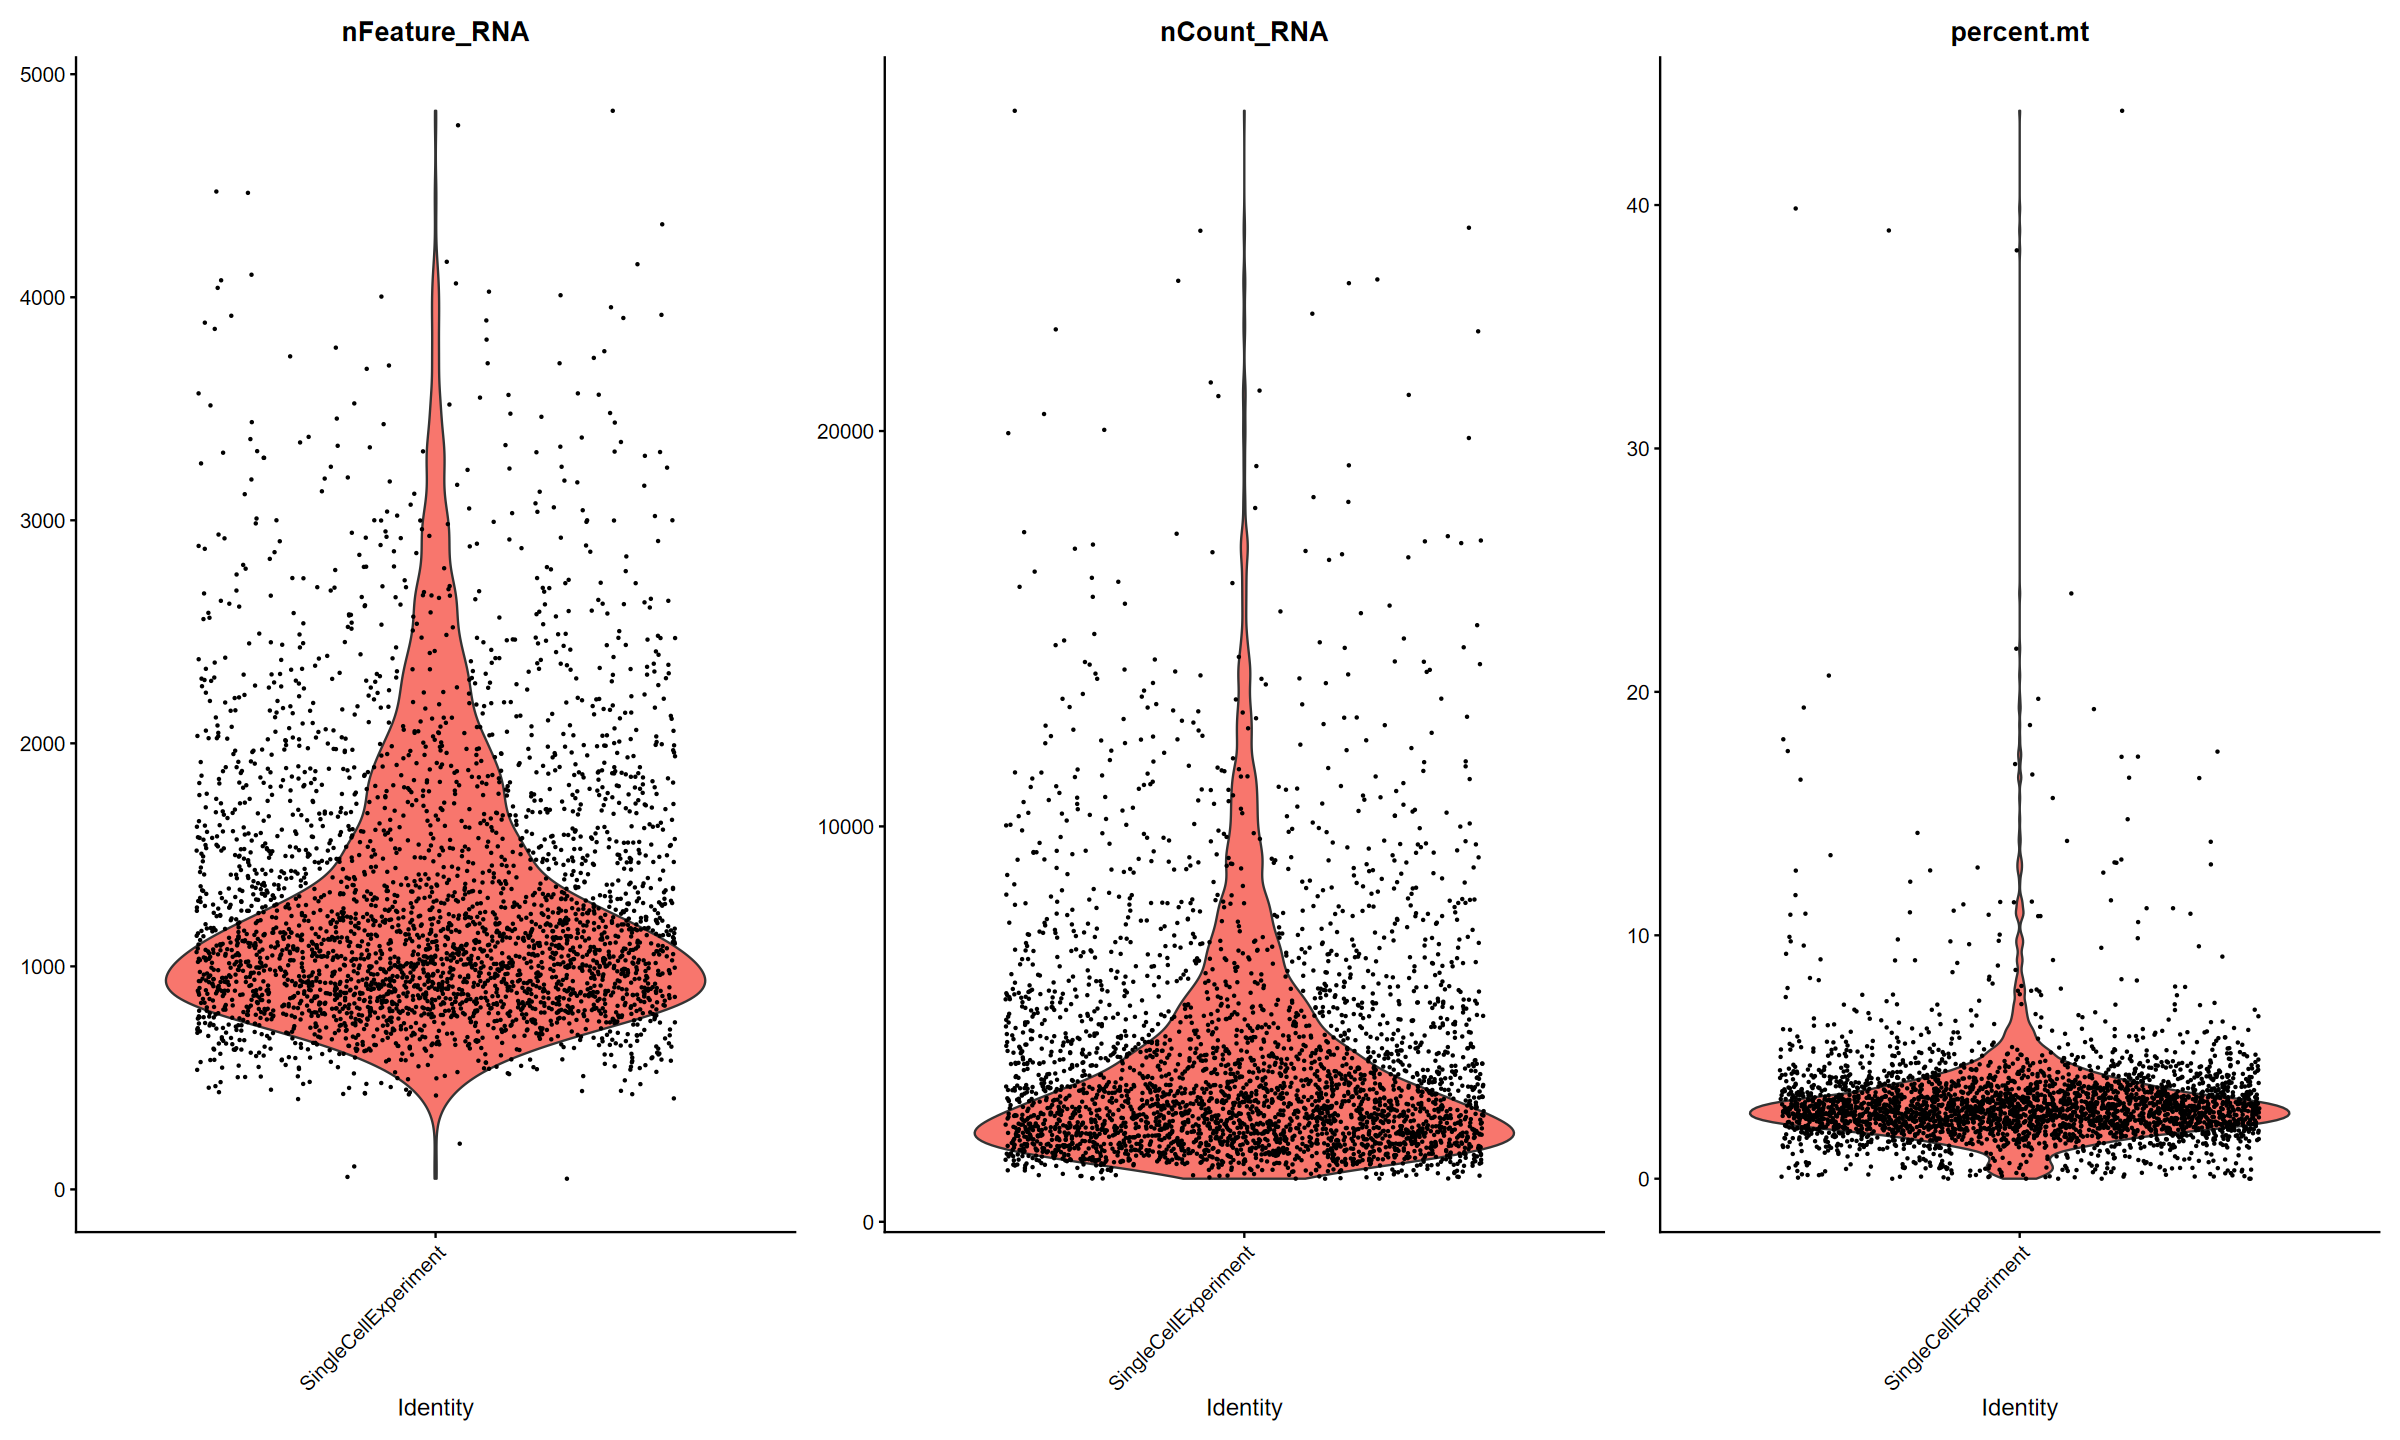

In [9]:
# Get percentage mt                      
sc.data[["percent.mt"]] <- PercentageFeatureSet(sc.data, pattern = sprintf("^%s-", "MT"))

# Get violin plots of QC metrics
VlnPlot(sc.data, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), 
        ncol = 3, pt.size = 0.2) + NoLegend()

In [ ]:
# Preprocessing function which performs a basic workflow for scRNA seq analysis
pre_process <- function(data, nFeatures_RNA = 200, nCounts_RNA = 3, percents.mt = 5, pattern = "MT", nCounts_RNA_max = 20000, resolutions = seq(0.5, 1.5, by = 0.1), k.weights = 100) {
    # Split
    data[["RNA"]] <- split(data[["RNA"]], f = data$orig.ident)
    
    # Get percentage mt                      
    data[["percent.mt"]] <- PercentageFeatureSet(data, pattern = sprintf("^%s-", pattern))
    
    # Subsets
    data <- subset(x = data, subset = nFeature_RNA >= nFeatures_RNA & nCount_RNA >= nCounts_RNA & percent.mt <= percents.mt & nCount_RNA <= nCounts_RNA_max)

    # Normalization
    data <- NormalizeData(data, normalization.method = "LogNormalize", scale.factor = 10000)
    
    # Find Variable features
    data <- FindVariableFeatures(data, selection.method = "vst", nfeatures = 2000)
    
    # Scale Data
    data <- ScaleData(data, vars.to.regress = c("percent.mt", "nFeature_RNA"))
    
    # Run PCA
    data <- RunPCA(data, npcs = 100, verbose=FALSE)

    # Get significant PCAs through Jackstrawplot
    data <- JackStraw(data, num.replicate = 100)
    data <- ScoreJackStraw(data, dims = 1:20)

    # Check the amount of significant pcs
    significant_pcs <- length(which(data@reductions$pca@jackstraw$overall.p.values < 0.01))

    # Run UMAP
    data <- RunUMAP(data, reduction = "pca", reduction.name = "umap_unintegrated", dims = 1:significant_pcs, verbose=FALSE)

    # Integrate
    data <- IntegrateLayers(object = data, method = CCAIntegration, orig.reduction = "pca", new.reduction = "integrated.cca", k.weight = k.weights,verbose = FALSE, dims= 1:significant_pcs)

    data[["RNA"]] <- JoinLayers(data[["RNA"]])

    # Post integration processing
    data <- RunPCA(data, npcs = 100, verbose=FALSE)

    # Get significant PCAs through Jackstrawplot
    data <- JackStraw(data, num.replicate = 100)
    data <- ScoreJackStraw(data, dims = 1:20)
    
    # Check the amount of significant pcs
    significant_pcs <- length(which(data@reductions$pca@jackstraw$overall.p.values < 0.05))

    # Clustering
    data <- FindNeighbors(data, reduction = "integrated.cca", dims = 1:significant_pcs)
    data <- FindClusters(data, resolution = resolutions)
    data <- RunUMAP(data, dims = 1:significant_pcs, reduction = "integrated.cca", reduction.name = "umap", verbose=FALSE)

    return(data)
}

# Input is a splitted Seurat Object
data <- pre_process(sc.data, nCounts_RNA_max = 15000)

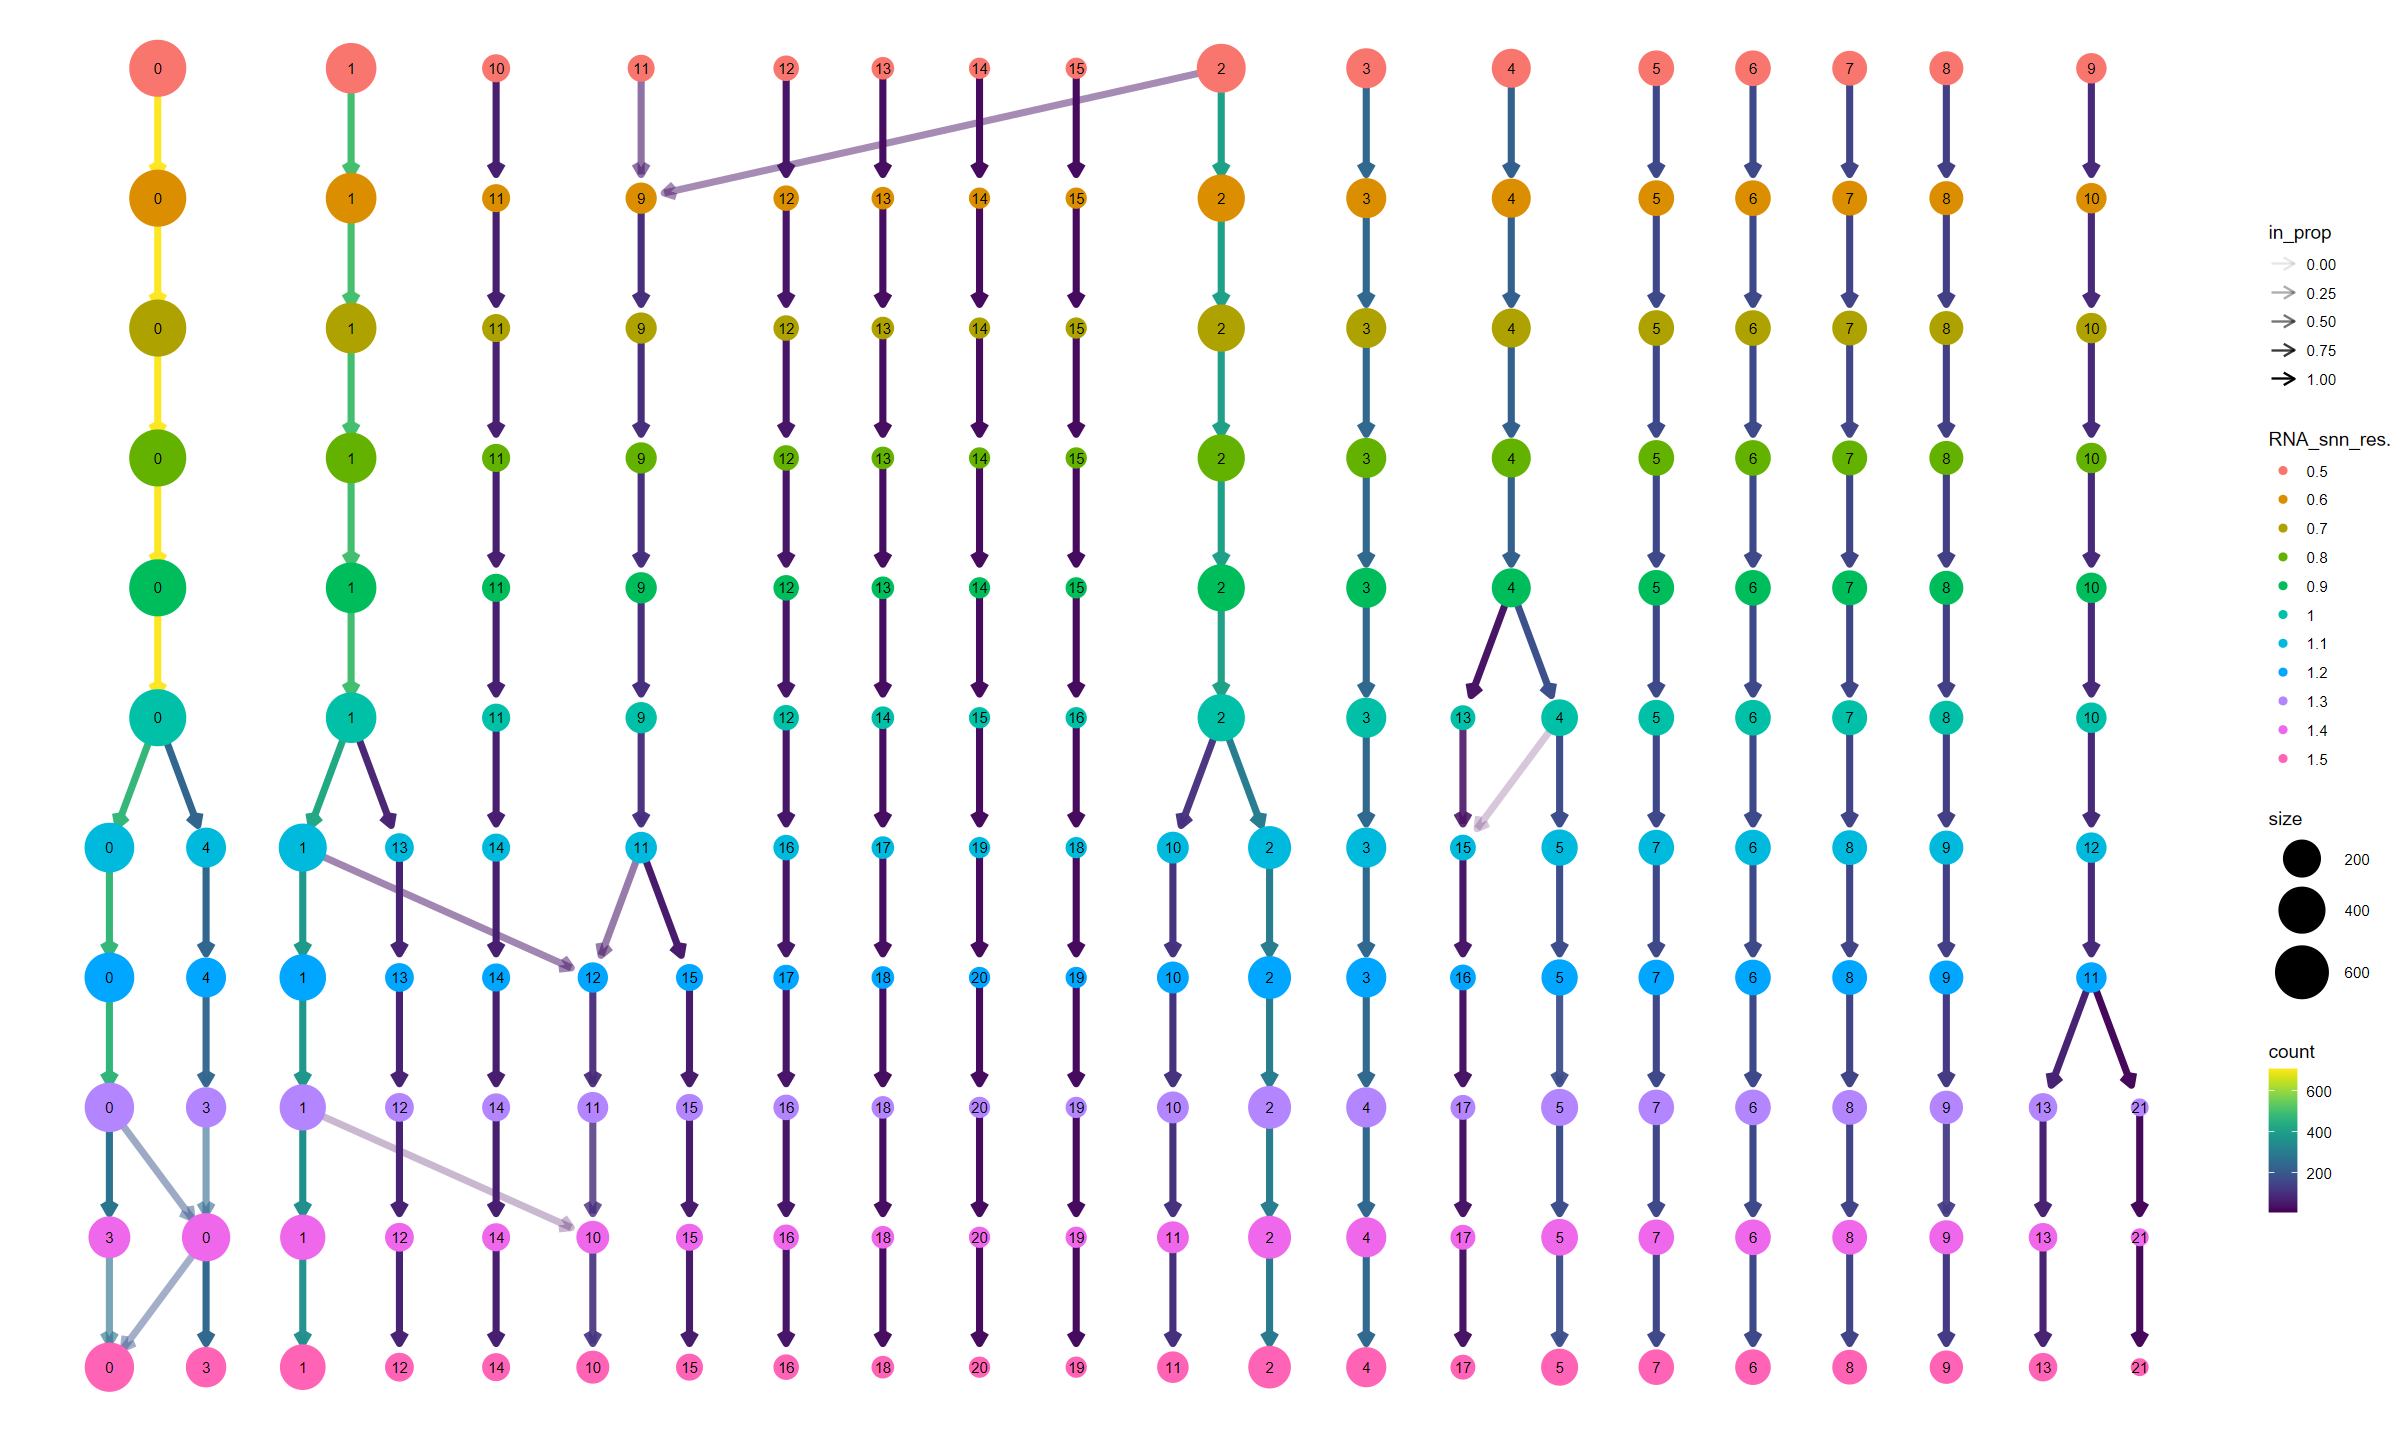

In [11]:
# This cell is meant to analyze the different resolutions and see which one is the best
clustree(data, prefix= "RNA_snn_res.", layout = "sugiyama")

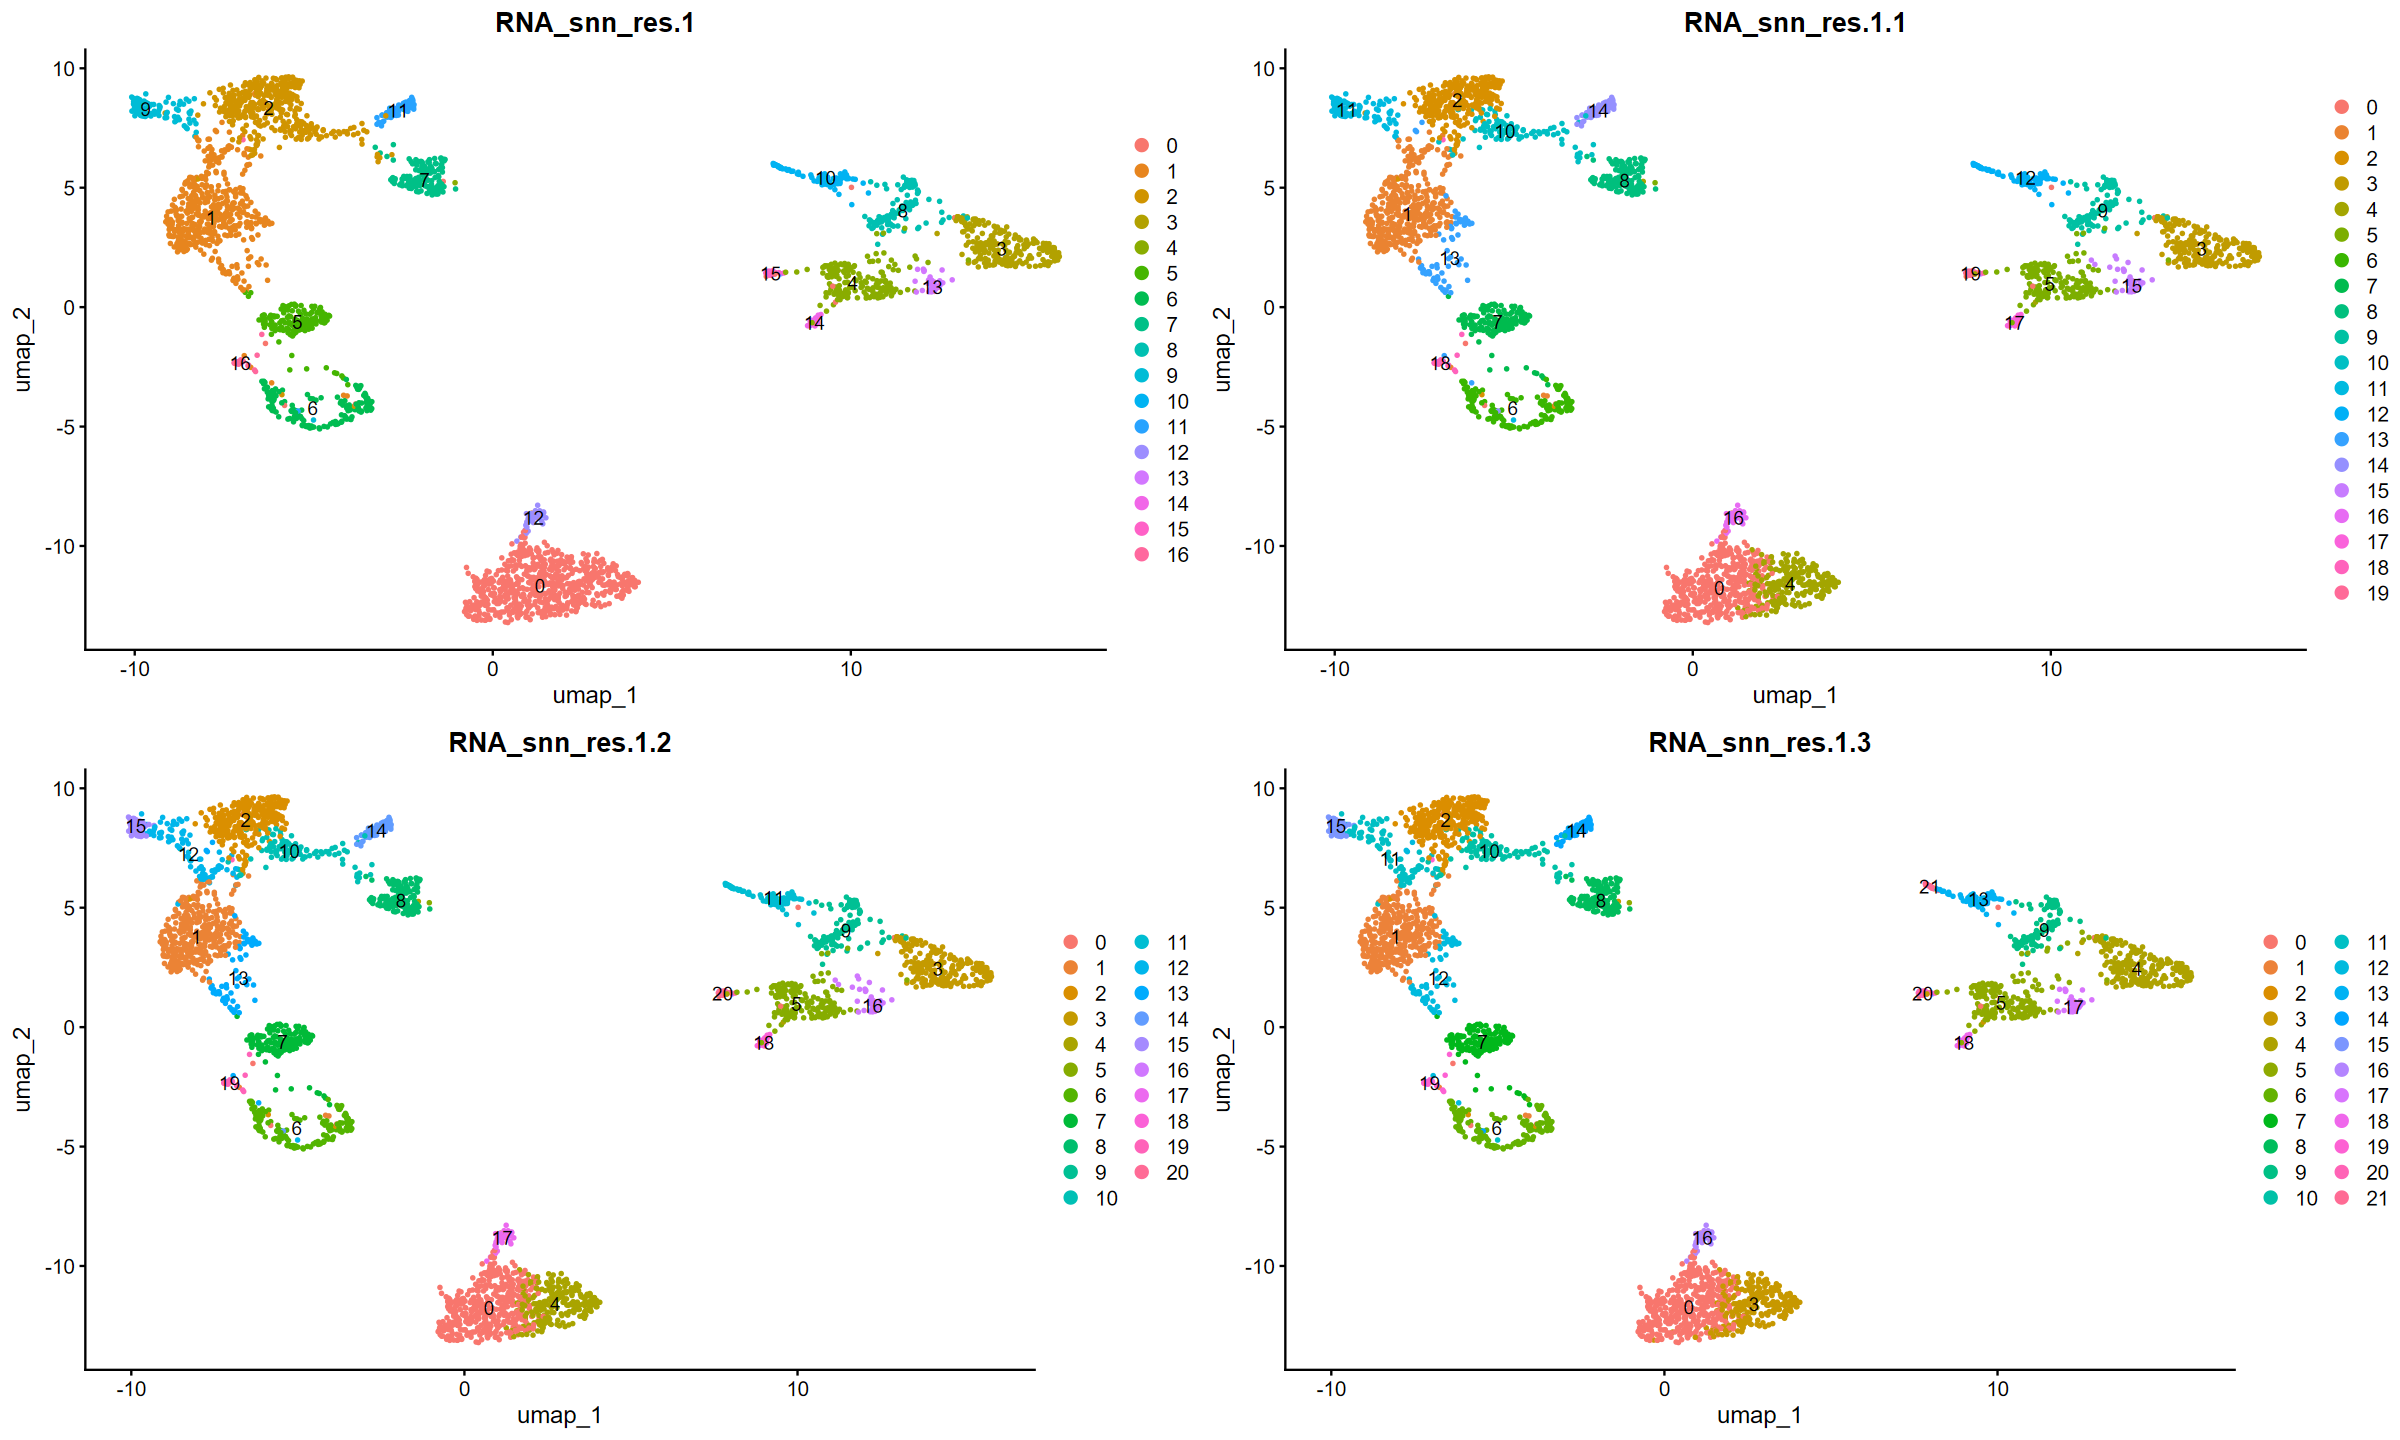

In [14]:
# Get DimPlots of different resolutions
res_1 <- DimPlot(data, reduction = "umap", group.by = "RNA_snn_res.1", label = T)
res_2 <- DimPlot(data, reduction = "umap", group.by = "RNA_snn_res.1.1", label = T)
res_3 <- DimPlot(data, reduction = "umap", group.by = "RNA_snn_res.1.2", label = T)
res_4 <- DimPlot(data, reduction = "umap", group.by = "RNA_snn_res.1.3", label = T)

# Plot
grid.arrange(res_1, res_2, res_3, res_4, ncol=2)

In [15]:
# Assign the slot "Seurat Cluster" to the desired resolution
data$seurat_clusters <- data$`RNA_snn_res.1.1`

# Winkels has written their genes in upper-case, therefore we need to convert it to lower case
# Convert row names to lowercase
rownames(data) <- tolower(rownames(data))
rownames(data) <- str_to_title(rownames(data))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
B cells,468,0,0,0,234,3,2,0,1,1,0,0,0,0,0,0,42,0,1,1
Dendritic cells,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
Erythrocytes,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Granulocytes,0,0,0,0,0,0,0,1,0,3,0,0,86,0,0,0,0,0,0,0
Macrophages,0,0,0,207,0,1,0,0,0,4,0,0,0,0,0,7,0,0,0,0
Monocytes,2,0,0,30,1,153,0,0,1,124,0,1,2,0,0,39,0,28,0,13
NK cells,0,1,22,0,0,1,0,0,31,0,2,93,0,0,0,0,1,0,0,0
T cells,0,423,279,0,0,11,157,157,111,0,103,8,1,72,65,0,2,1,23,4


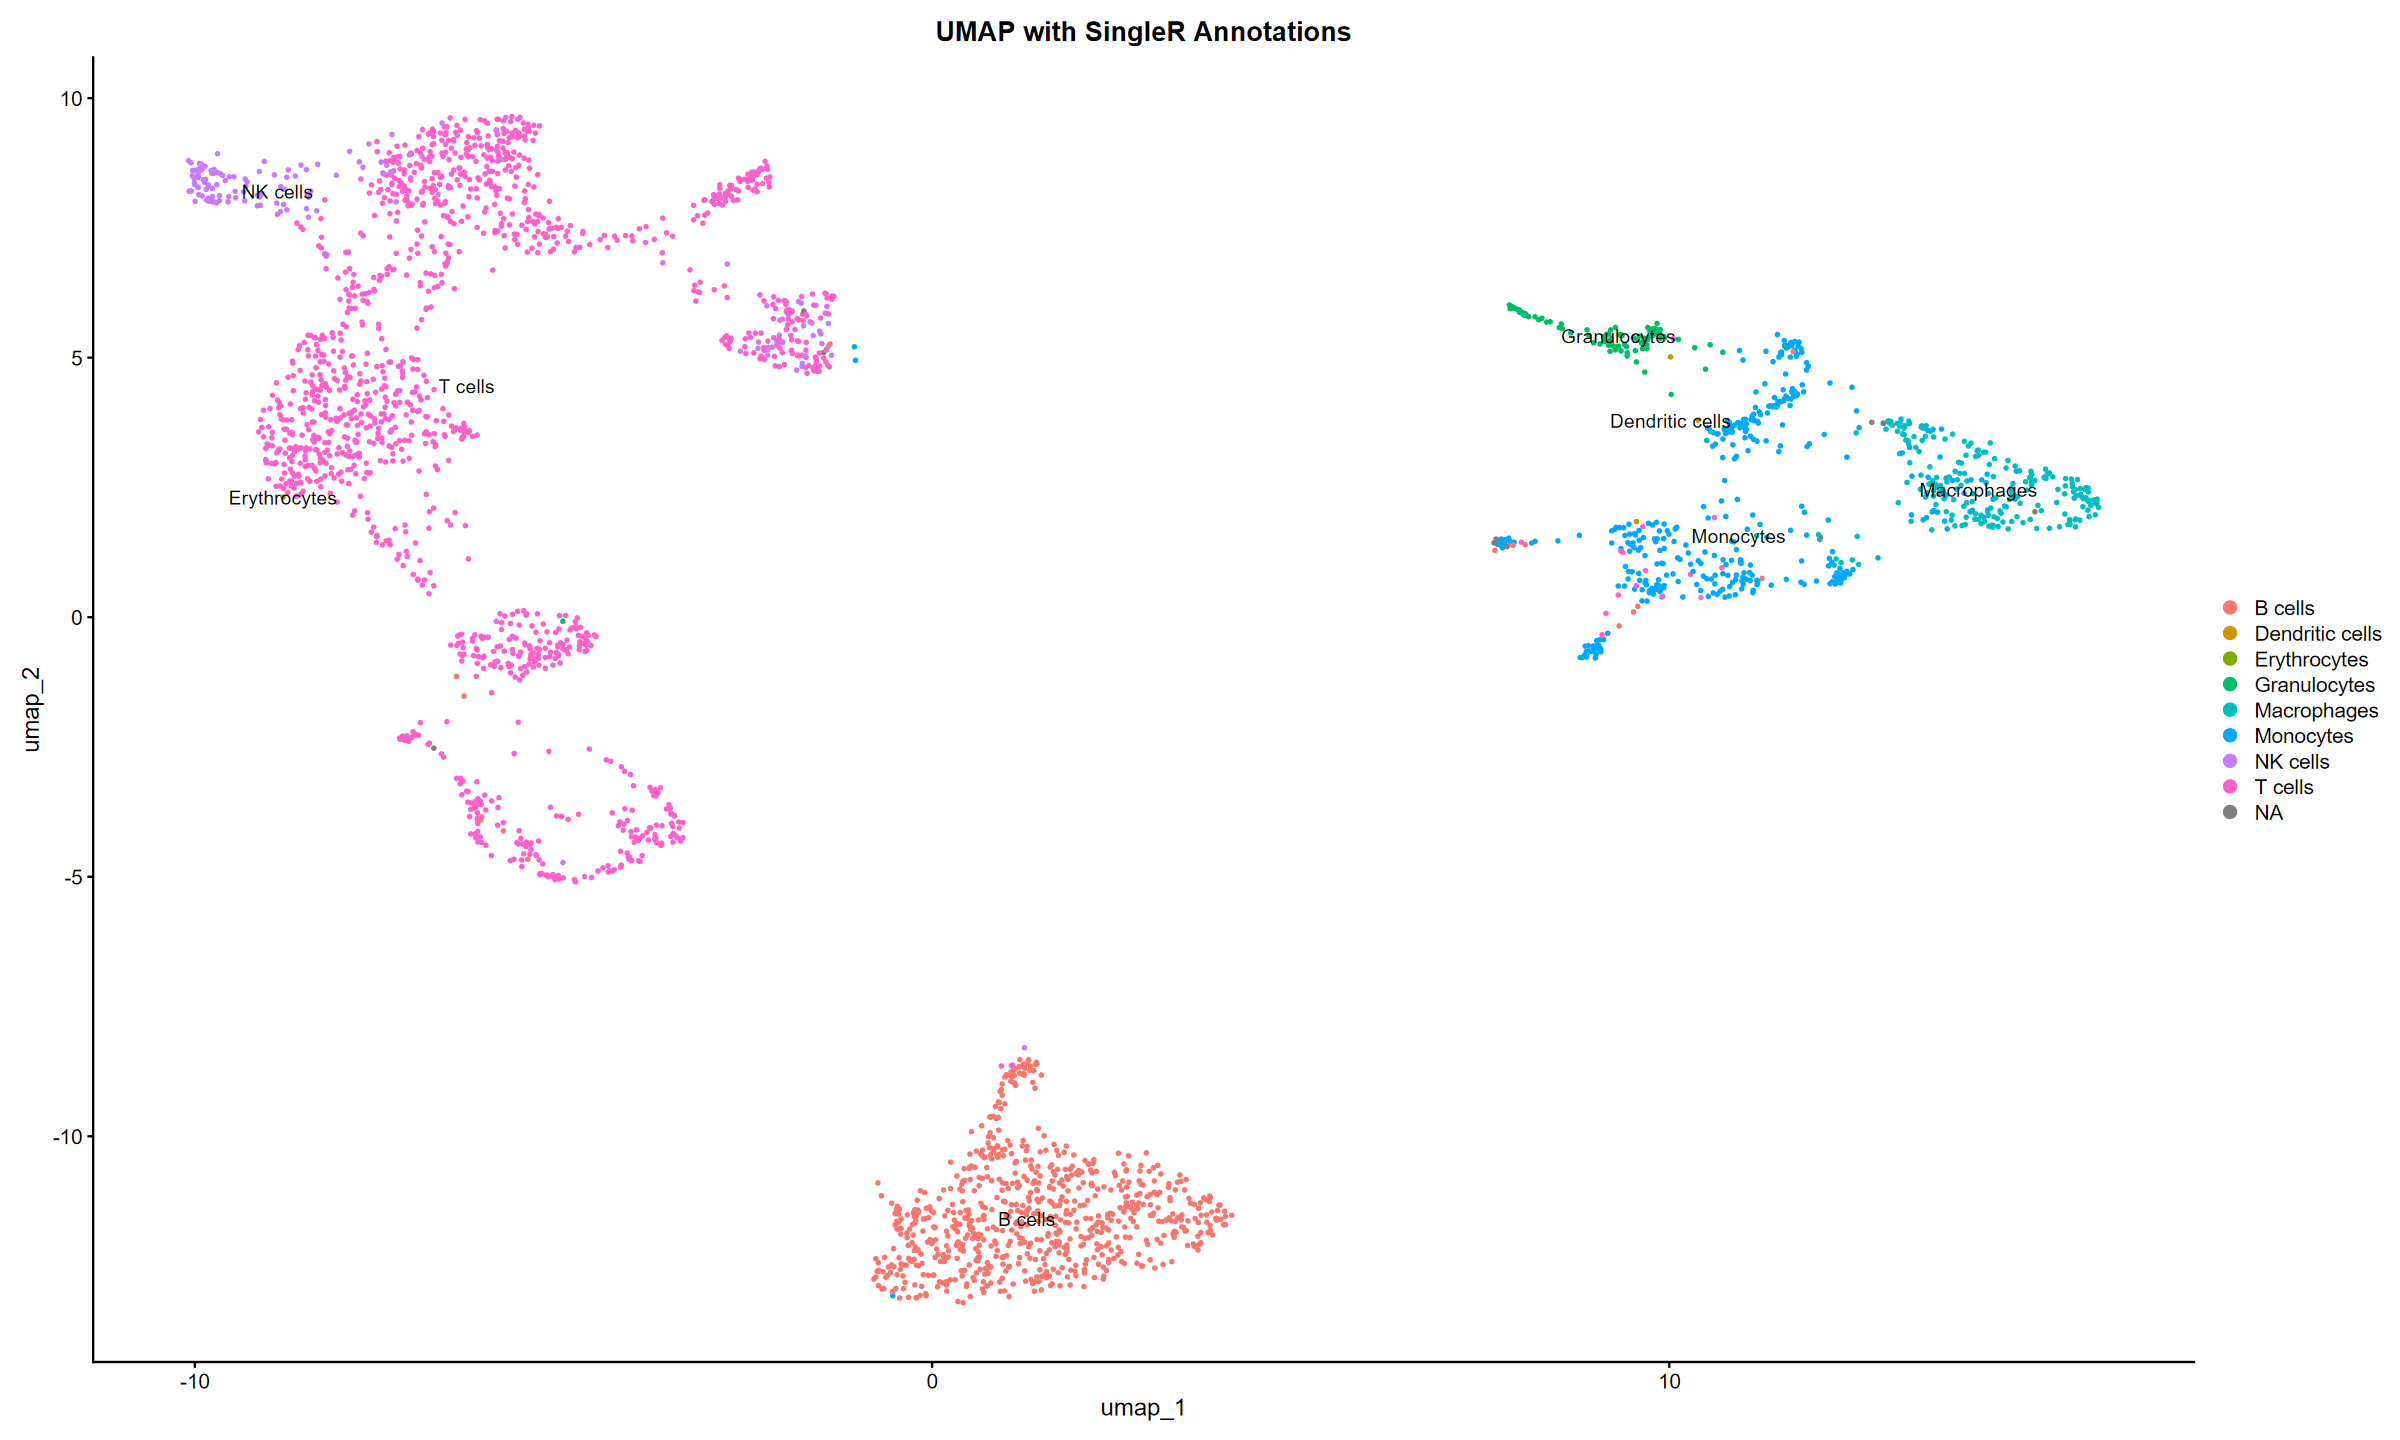

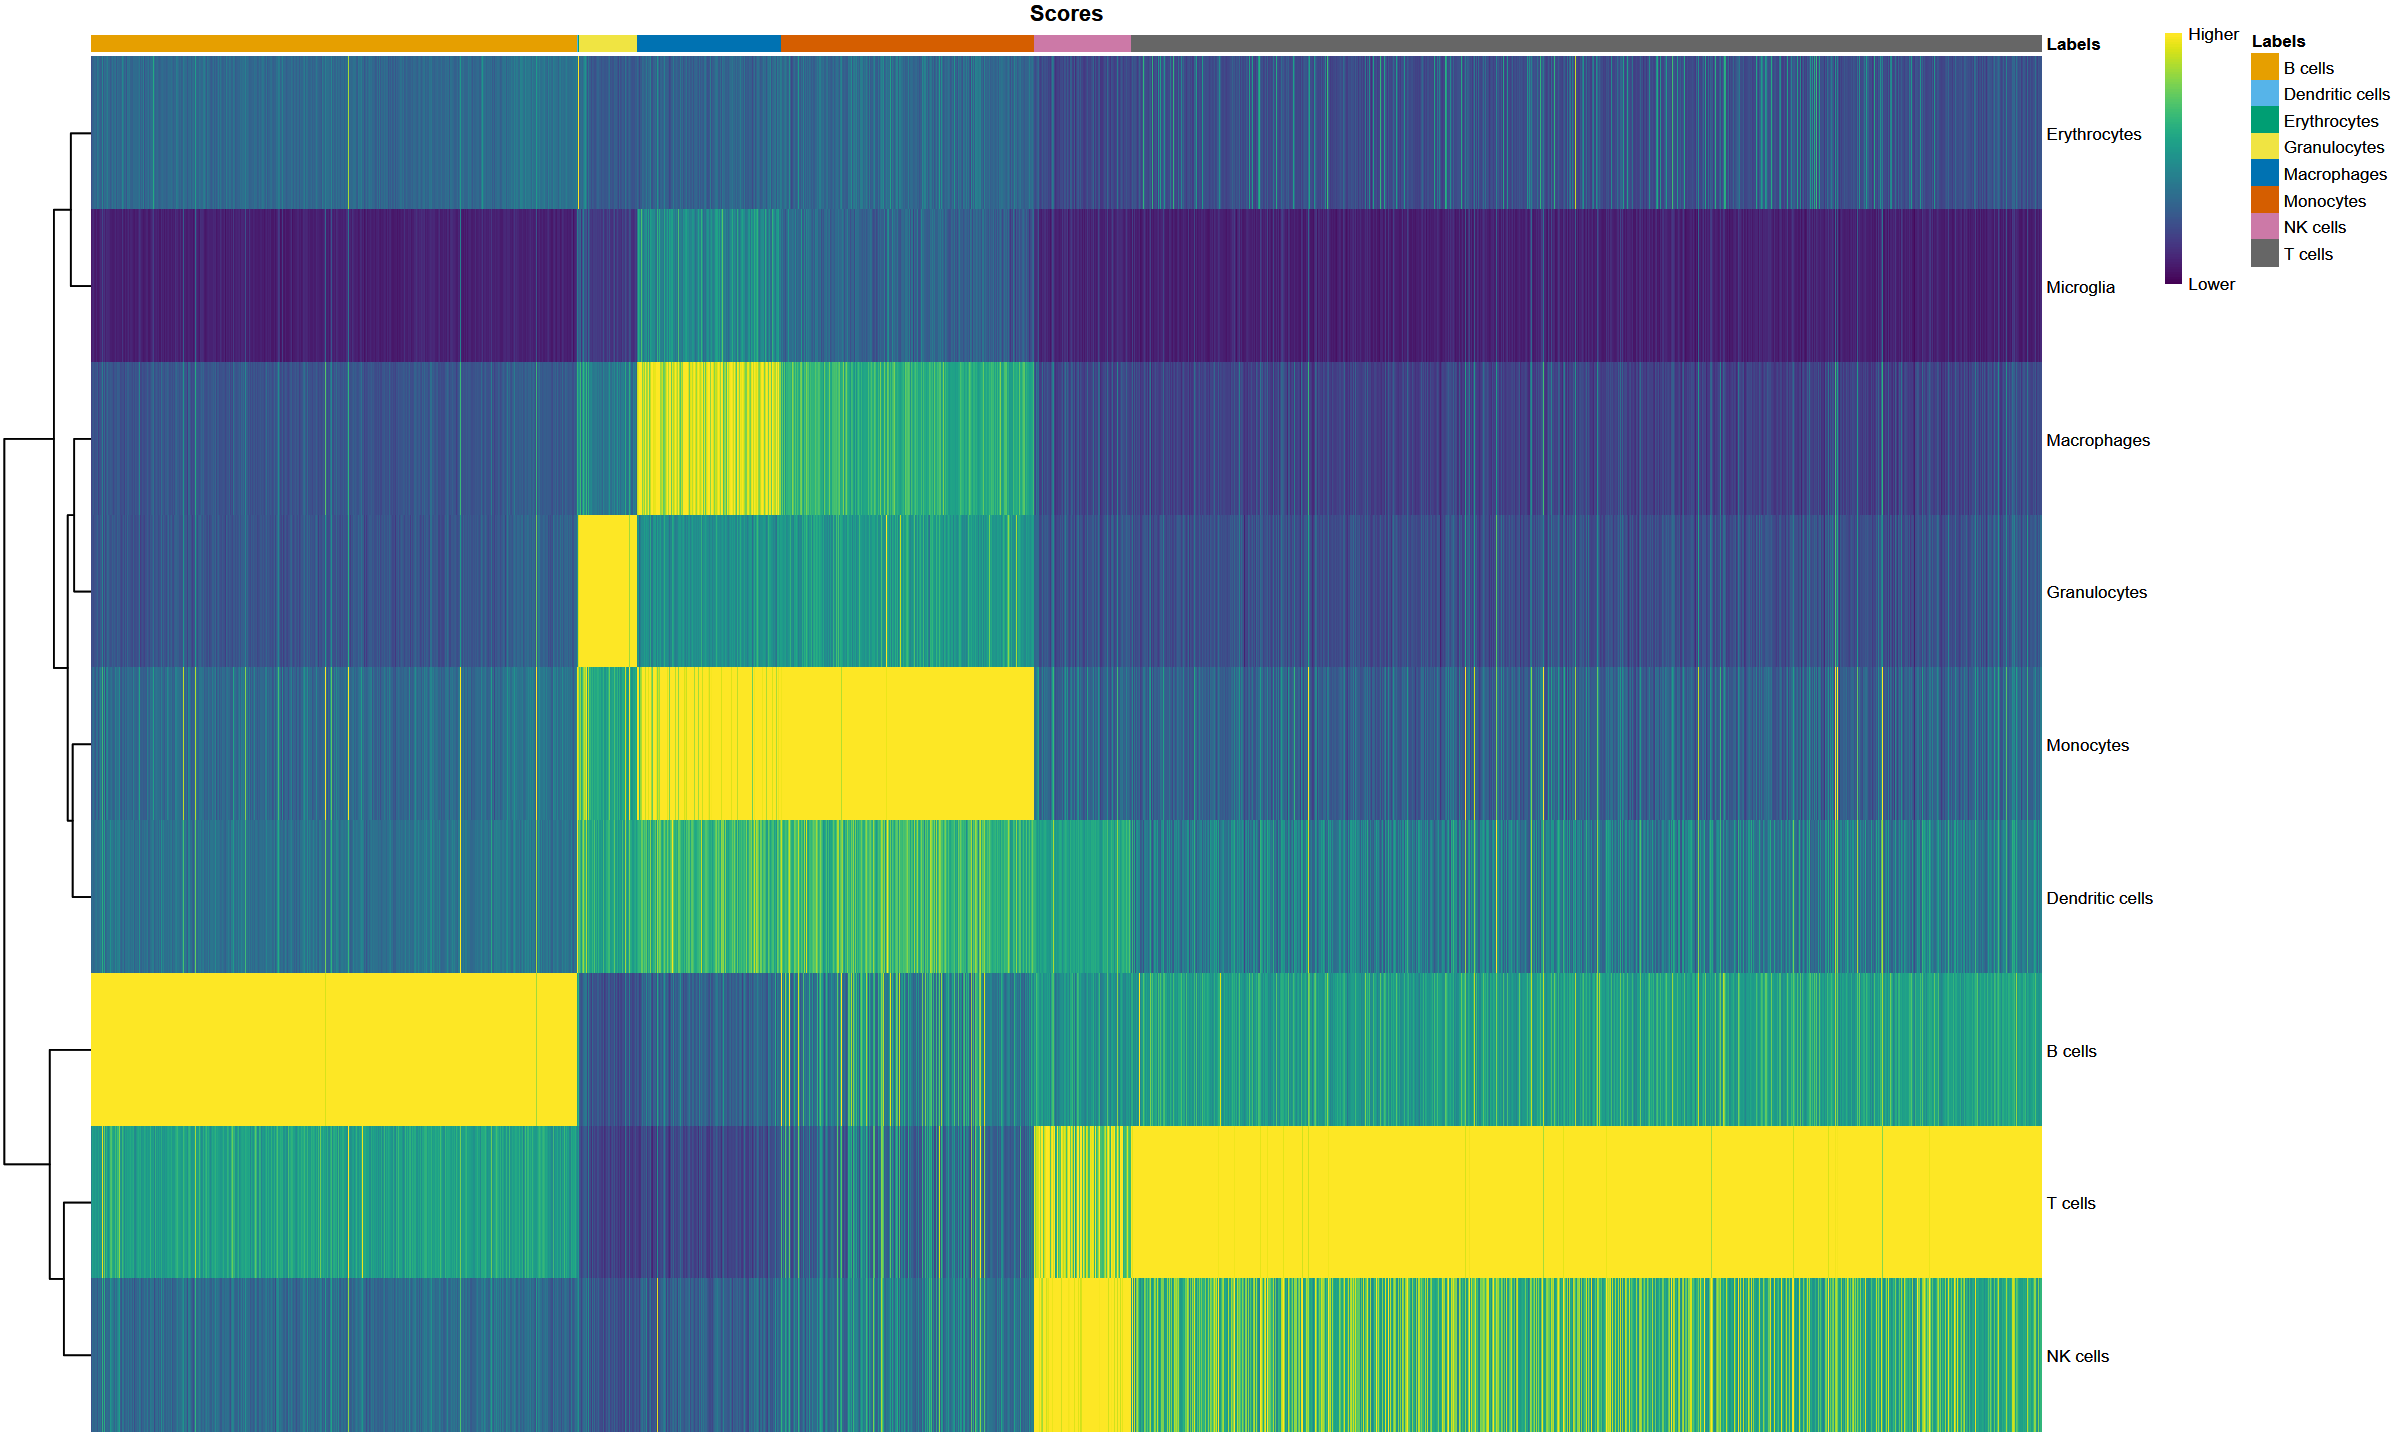

In [16]:
# Annotation
# Get reference atlas from CellDex
MouseRNAseqData <- celldex::MouseRNAseqData()

# Convert to SCE to use SingleR
data.sce <- as.SingleCellExperiment(data)

# Predict cell types
pred.MouseRNAseqData <- SingleR(test = data.sce, ref = MouseRNAseqData, assay.type.test=1,
    labels = MouseRNAseqData$label.main)

# View annotations
cluster_table <- cbind(table(pred.MouseRNAseqData$pruned.labels,data.sce$seurat_clusters))
cluster_table

# Add SingleR predicted labels to Seurat metadata
data$SingleR_Labels <- pred.MouseRNAseqData$pruned.labels

# UMAP plot with SingleR labels
DimPlot(data, reduction = "umap", group.by = "SingleR_Labels", label = TRUE) + 
    ggtitle("UMAP with SingleR Annotations")

# Heatmap
plotScoreHeatmap(pred.MouseRNAseqData, max.labels = length(unique(pred.MouseRNAseqData$pruned.labels)))

In [17]:
ncol(data)

[1] 3041

In [25]:
# Function to get the a specific cell type
get_macrophages <- function(data, table, cell_type = "Macrophages") {

    # Find clusters where atleast > 15% is classified as macrophages
    clusters <- which(t(cluster_table[cell_type, ] / colSums(cluster_table) * 100) > 5) - 1

    # Get subsets by first filtering on macrophage dominant clusters
    data <- subset(data, subset = seurat_clusters %in% clusters)

    # And then only select the macrophages
    data <- subset(data, subset = SingleR_Labels == cell_type)

    return(data)
}

# Get myeloid cells
macrophages <- get_macrophages(data, cluster_table)
monocytes <- get_macrophages(data, cluster_table, cell_type = "Monocytes")


# Merge the Seurat objects
myeloid_cells <- merge(macrophages, y=monocytes)

# Merge layers
myeloid_cells[["RNA"]] <- JoinLayers(myeloid_cells[["RNA"]])

Warning message:
"Removing 2 cells missing data for vars requested"
Warning message:
"Removing 9 cells missing data for vars requested"


In [54]:
ncol(myeloid_cells)

[1] 601

In [34]:
# Reprocess the subset
# To reintegrate, there needs to be a new Seurat Object created
myeloid_data <- CreateSeuratObject(counts = myeloid_cells@assays$RNA$counts)
myeloid_data <- pre_process(myeloid_data, resolutions = seq(0.4, 1.4, by=0.1), pattern="Mt", k.weights=99)

Normalizing layer: counts.WD20

Normalizing layer: counts.CD20

Normalizing layer: counts.CD8

Finding variable features for layer counts.WD20

Finding variable features for layer counts.CD20

Finding variable features for layer counts.CD8

Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"pseudoinverse used at -1.6946"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"neighborhood radius 0.30103"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"reciprocal condition number  3.9329e-15"
Regressing out percent.mt, nFeature_RNA

Centering and scaling data matrix



[1] "!!!!!!!!!!!!!!!!"
[1] 20
[1] "!!!!!!!!!!!!!!!!"
[1] 20


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 601
Number of edges: 18610

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8462
Number of communities: 5
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 601
Number of edges: 18610

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8185
Number of communities: 5
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 601
Number of edges: 18610

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7909
Number of communities: 5
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 601
Number of edges: 18610

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7648
Number of communities: 8
Elapsed time: 0 seconds
Modularity Optimizer version

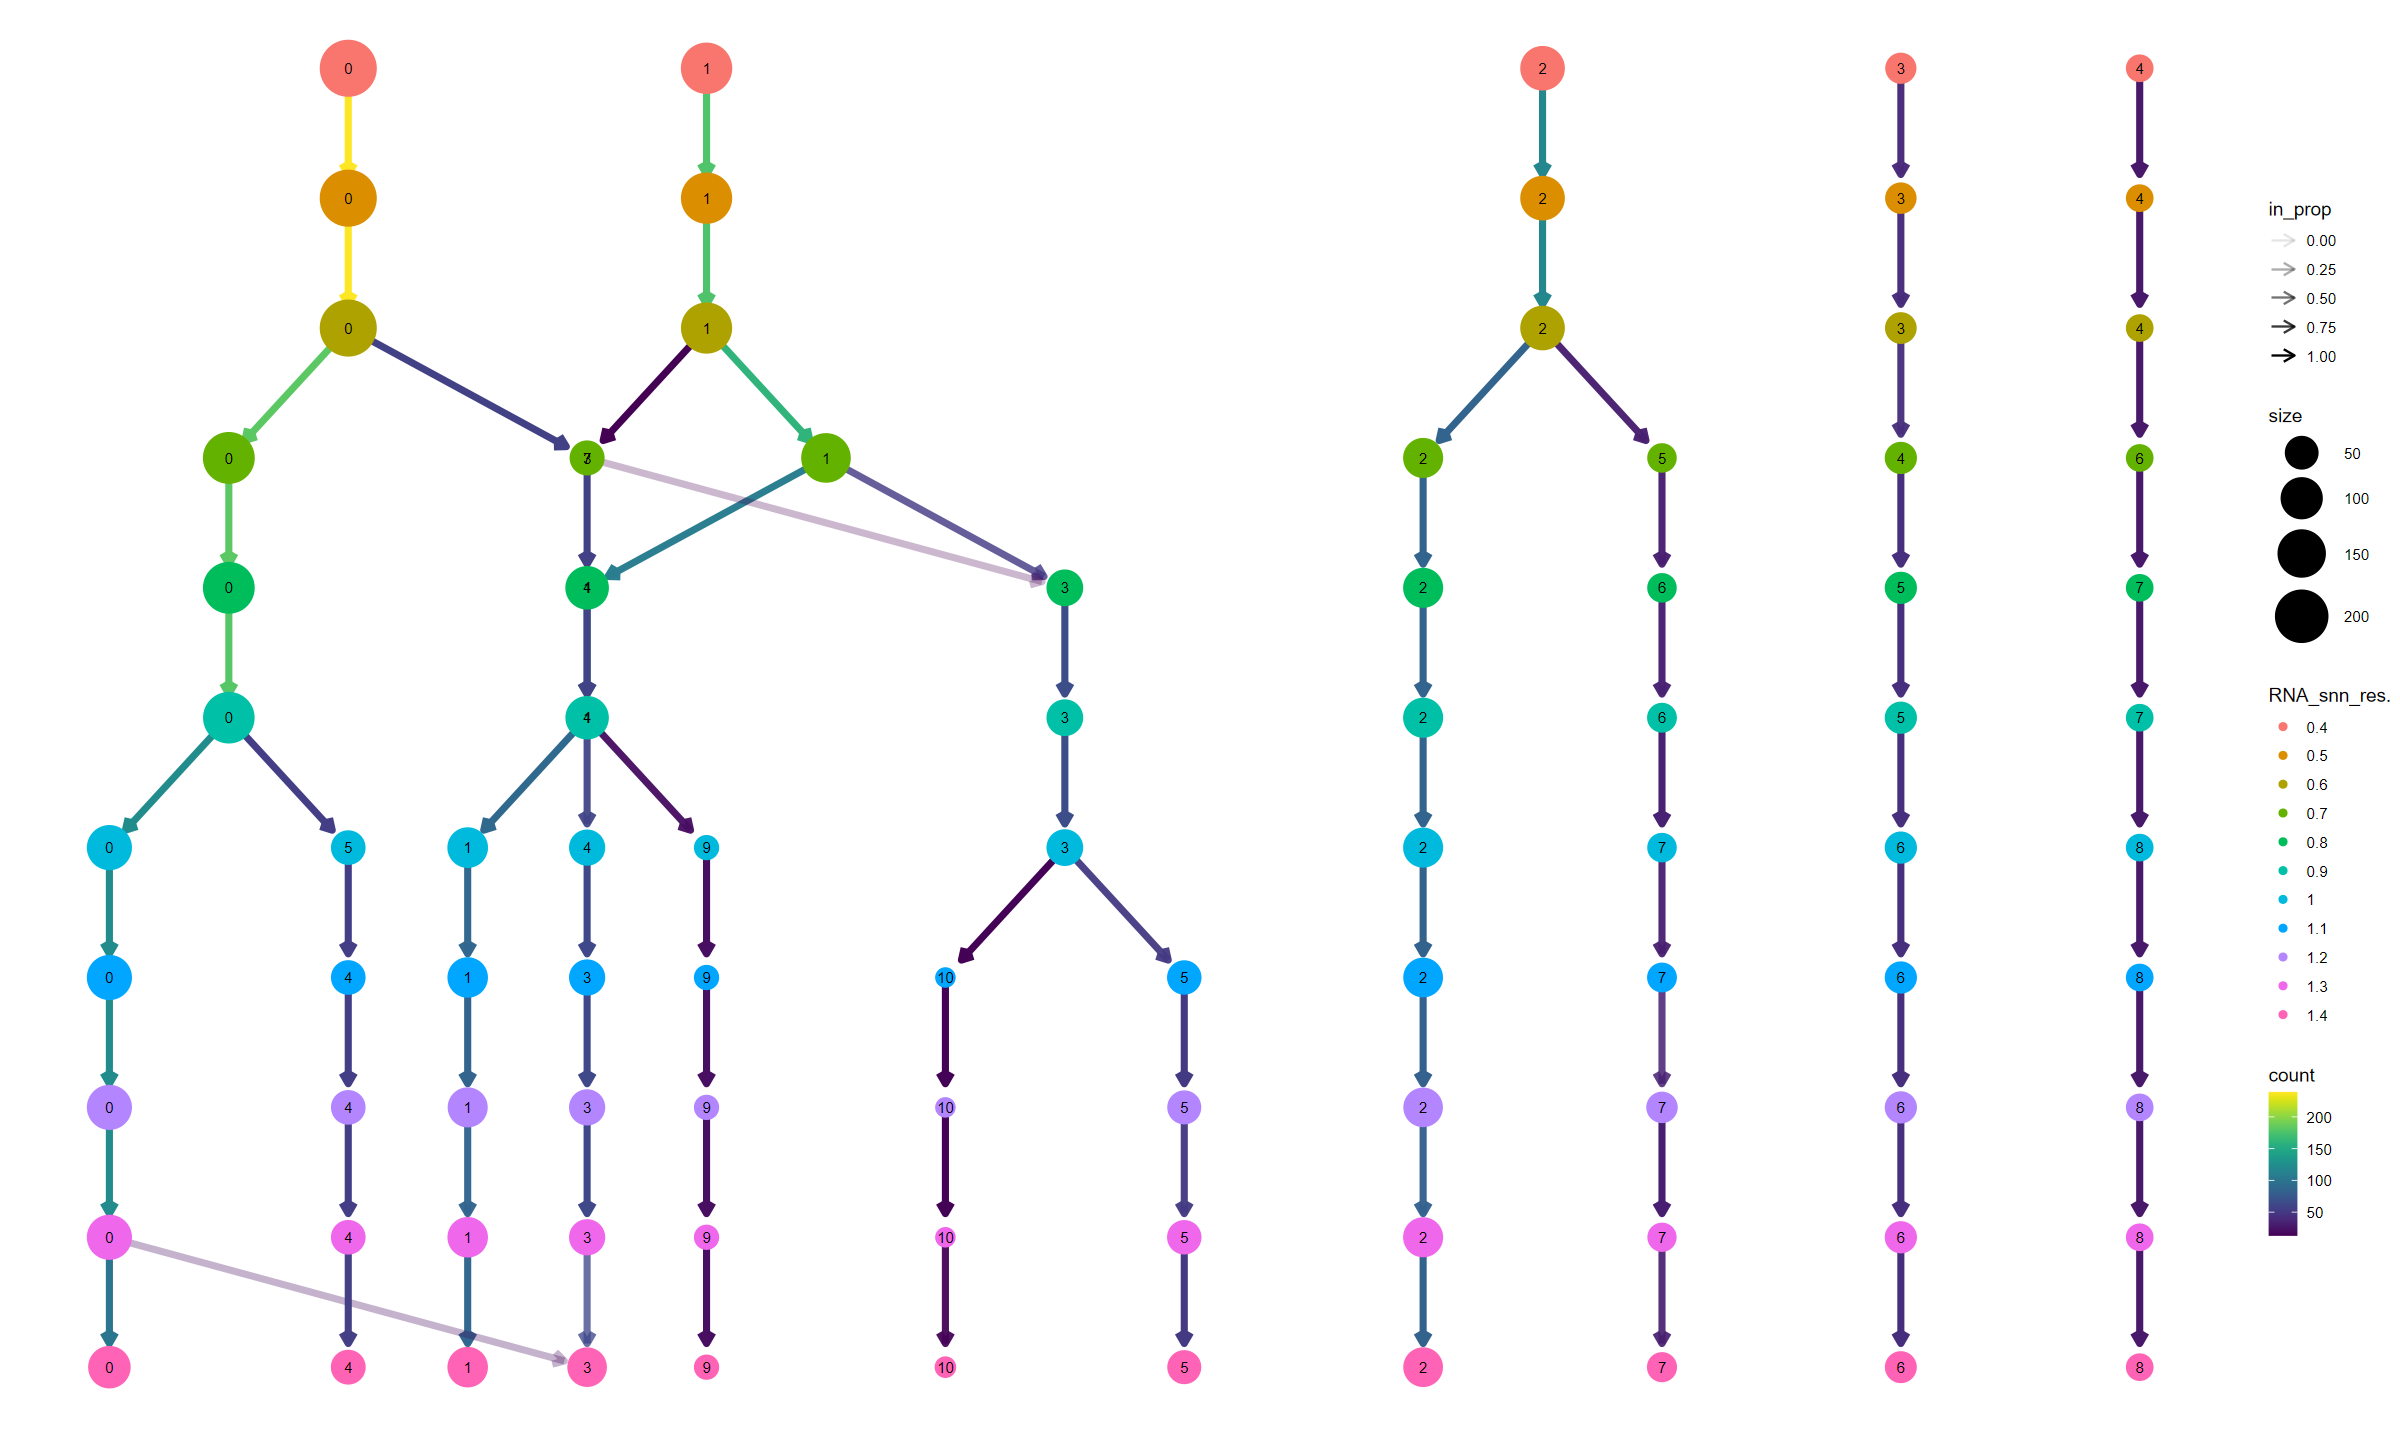

In [36]:
# View the clustree again for the best resolution
clustree(myeloid_data, prefix= "RNA_snn_res.", layout = "sugiyama")

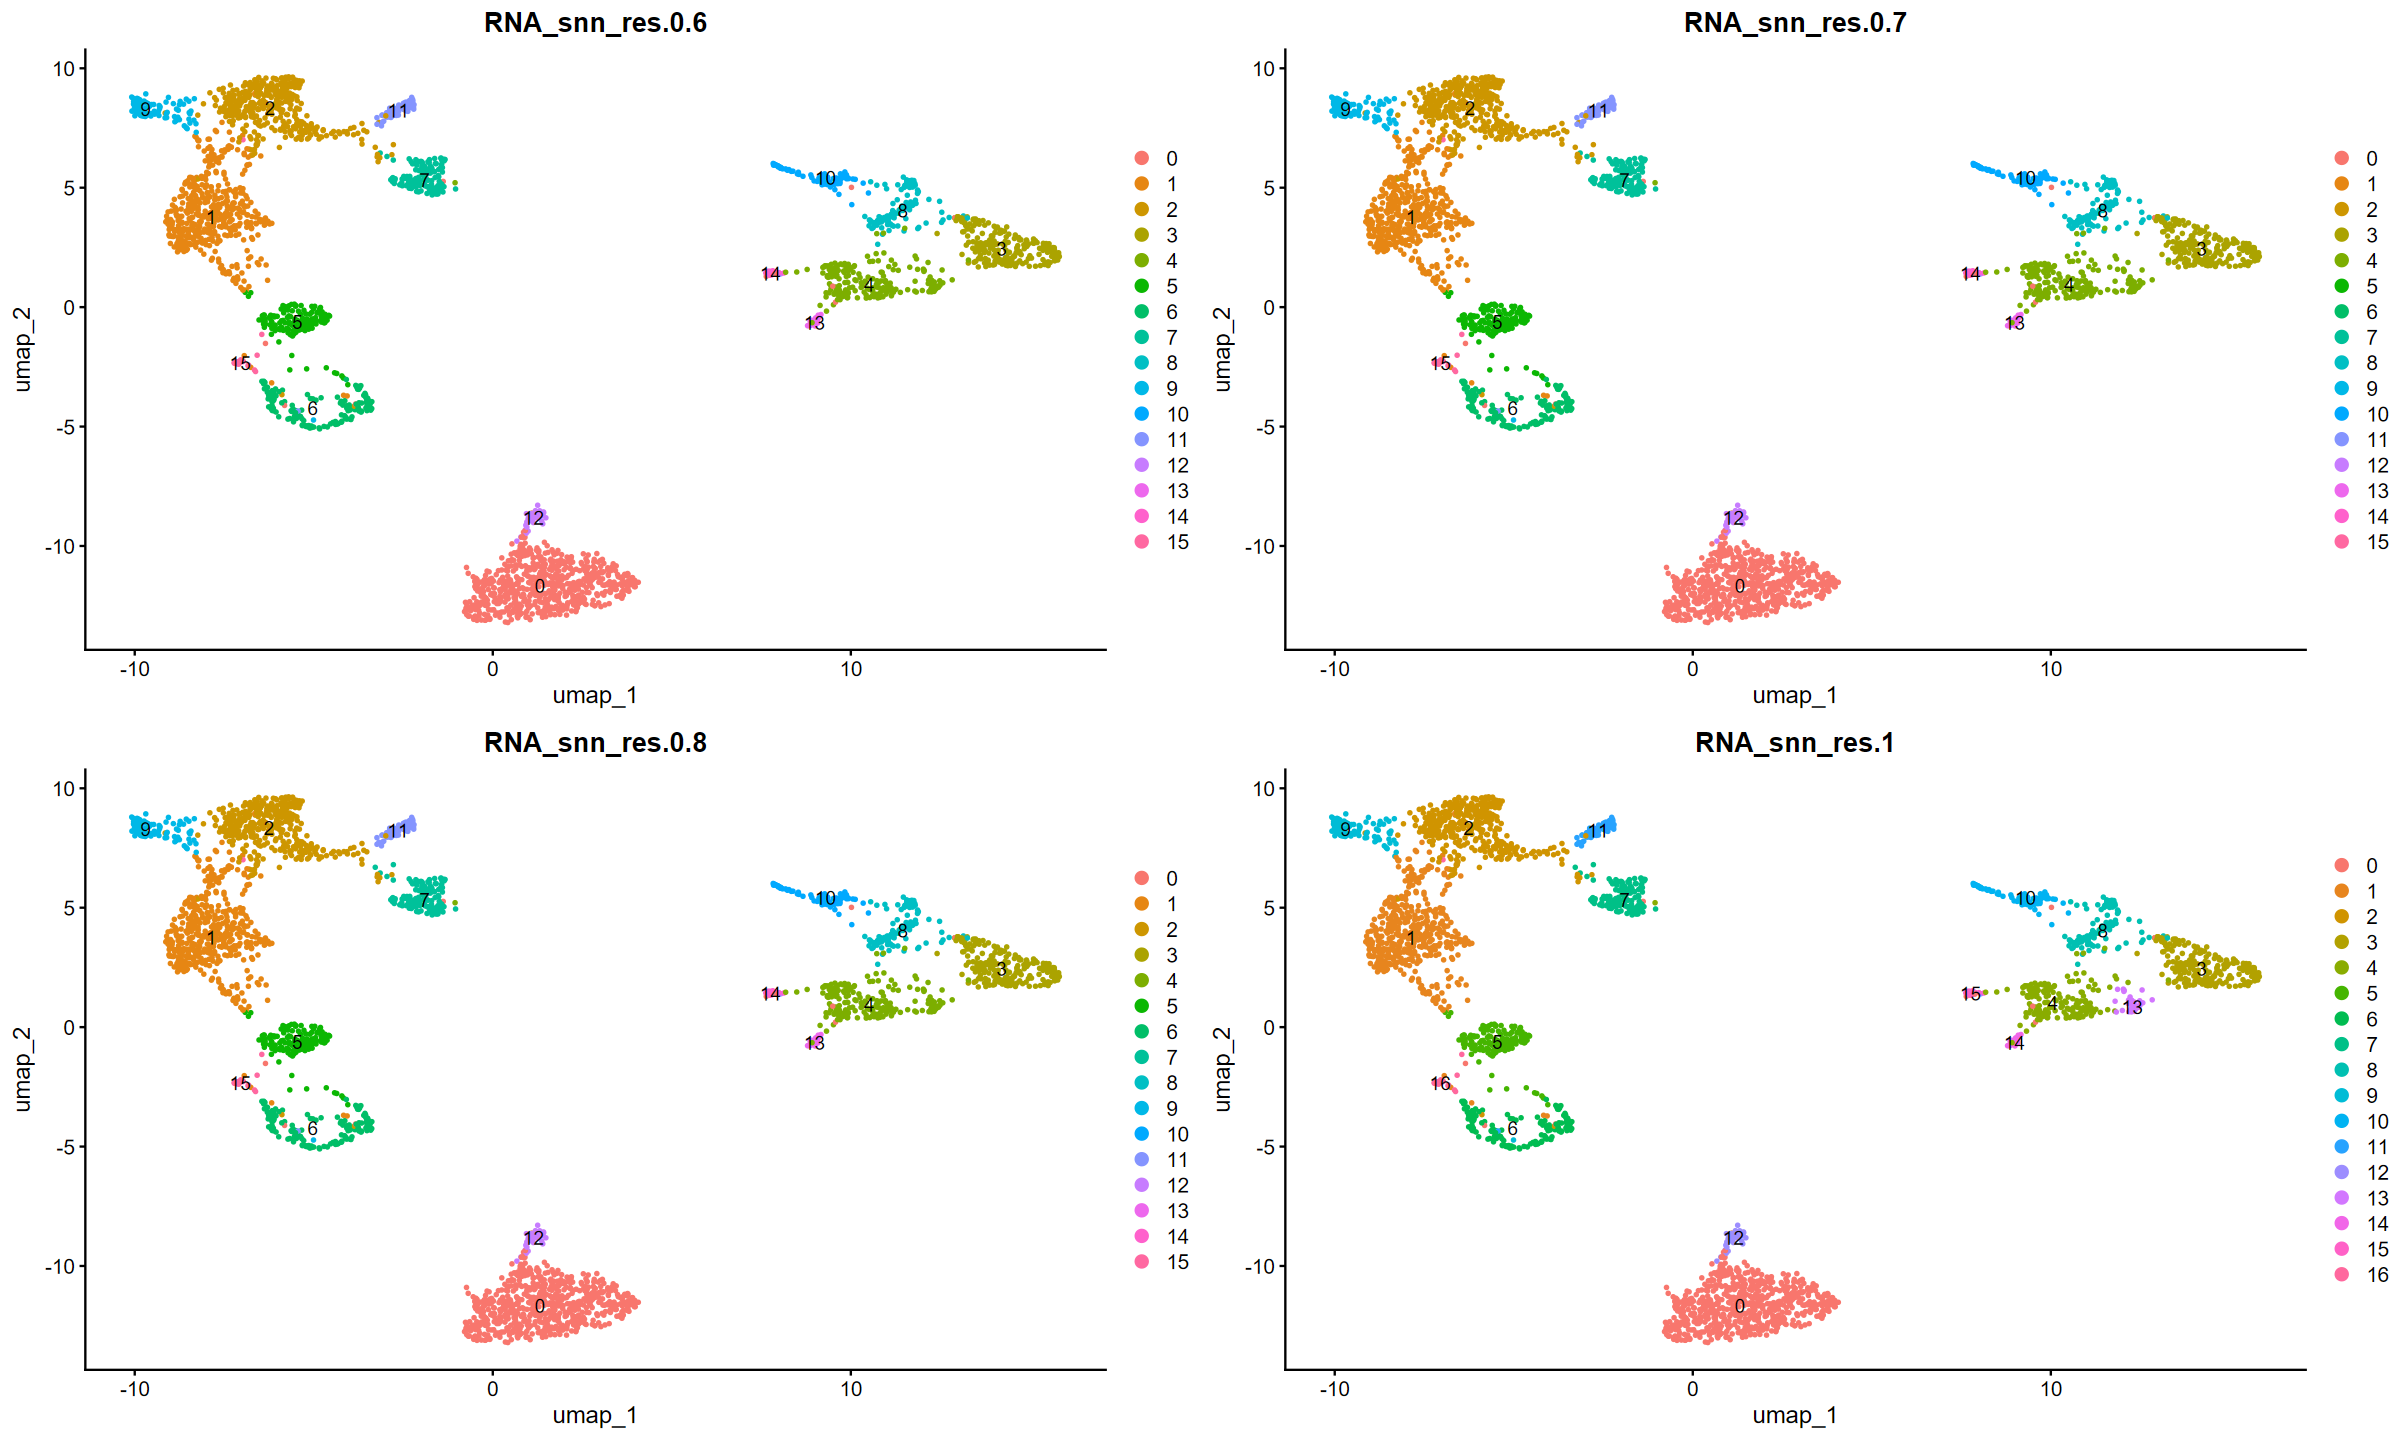

In [37]:
# Get DimPlots of different resolutions
res_1 <- DimPlot(data, reduction = "umap", group.by = "RNA_snn_res.0.6", label = T)
res_2 <- DimPlot(data, reduction = "umap", group.by = "RNA_snn_res.0.7", label = T)
res_3 <- DimPlot(data, reduction = "umap", group.by = "RNA_snn_res.0.8", label = T)
res_4 <- DimPlot(data, reduction = "umap", group.by = "RNA_snn_res.1", label = T)

# Plot
grid.arrange(res_1, res_2, res_3, res_4, ncol=2)

In [43]:
# Assign resolution 
myeloid_data$seurat_clusters <- myeloid_data$`RNA_snn_res.0.8`

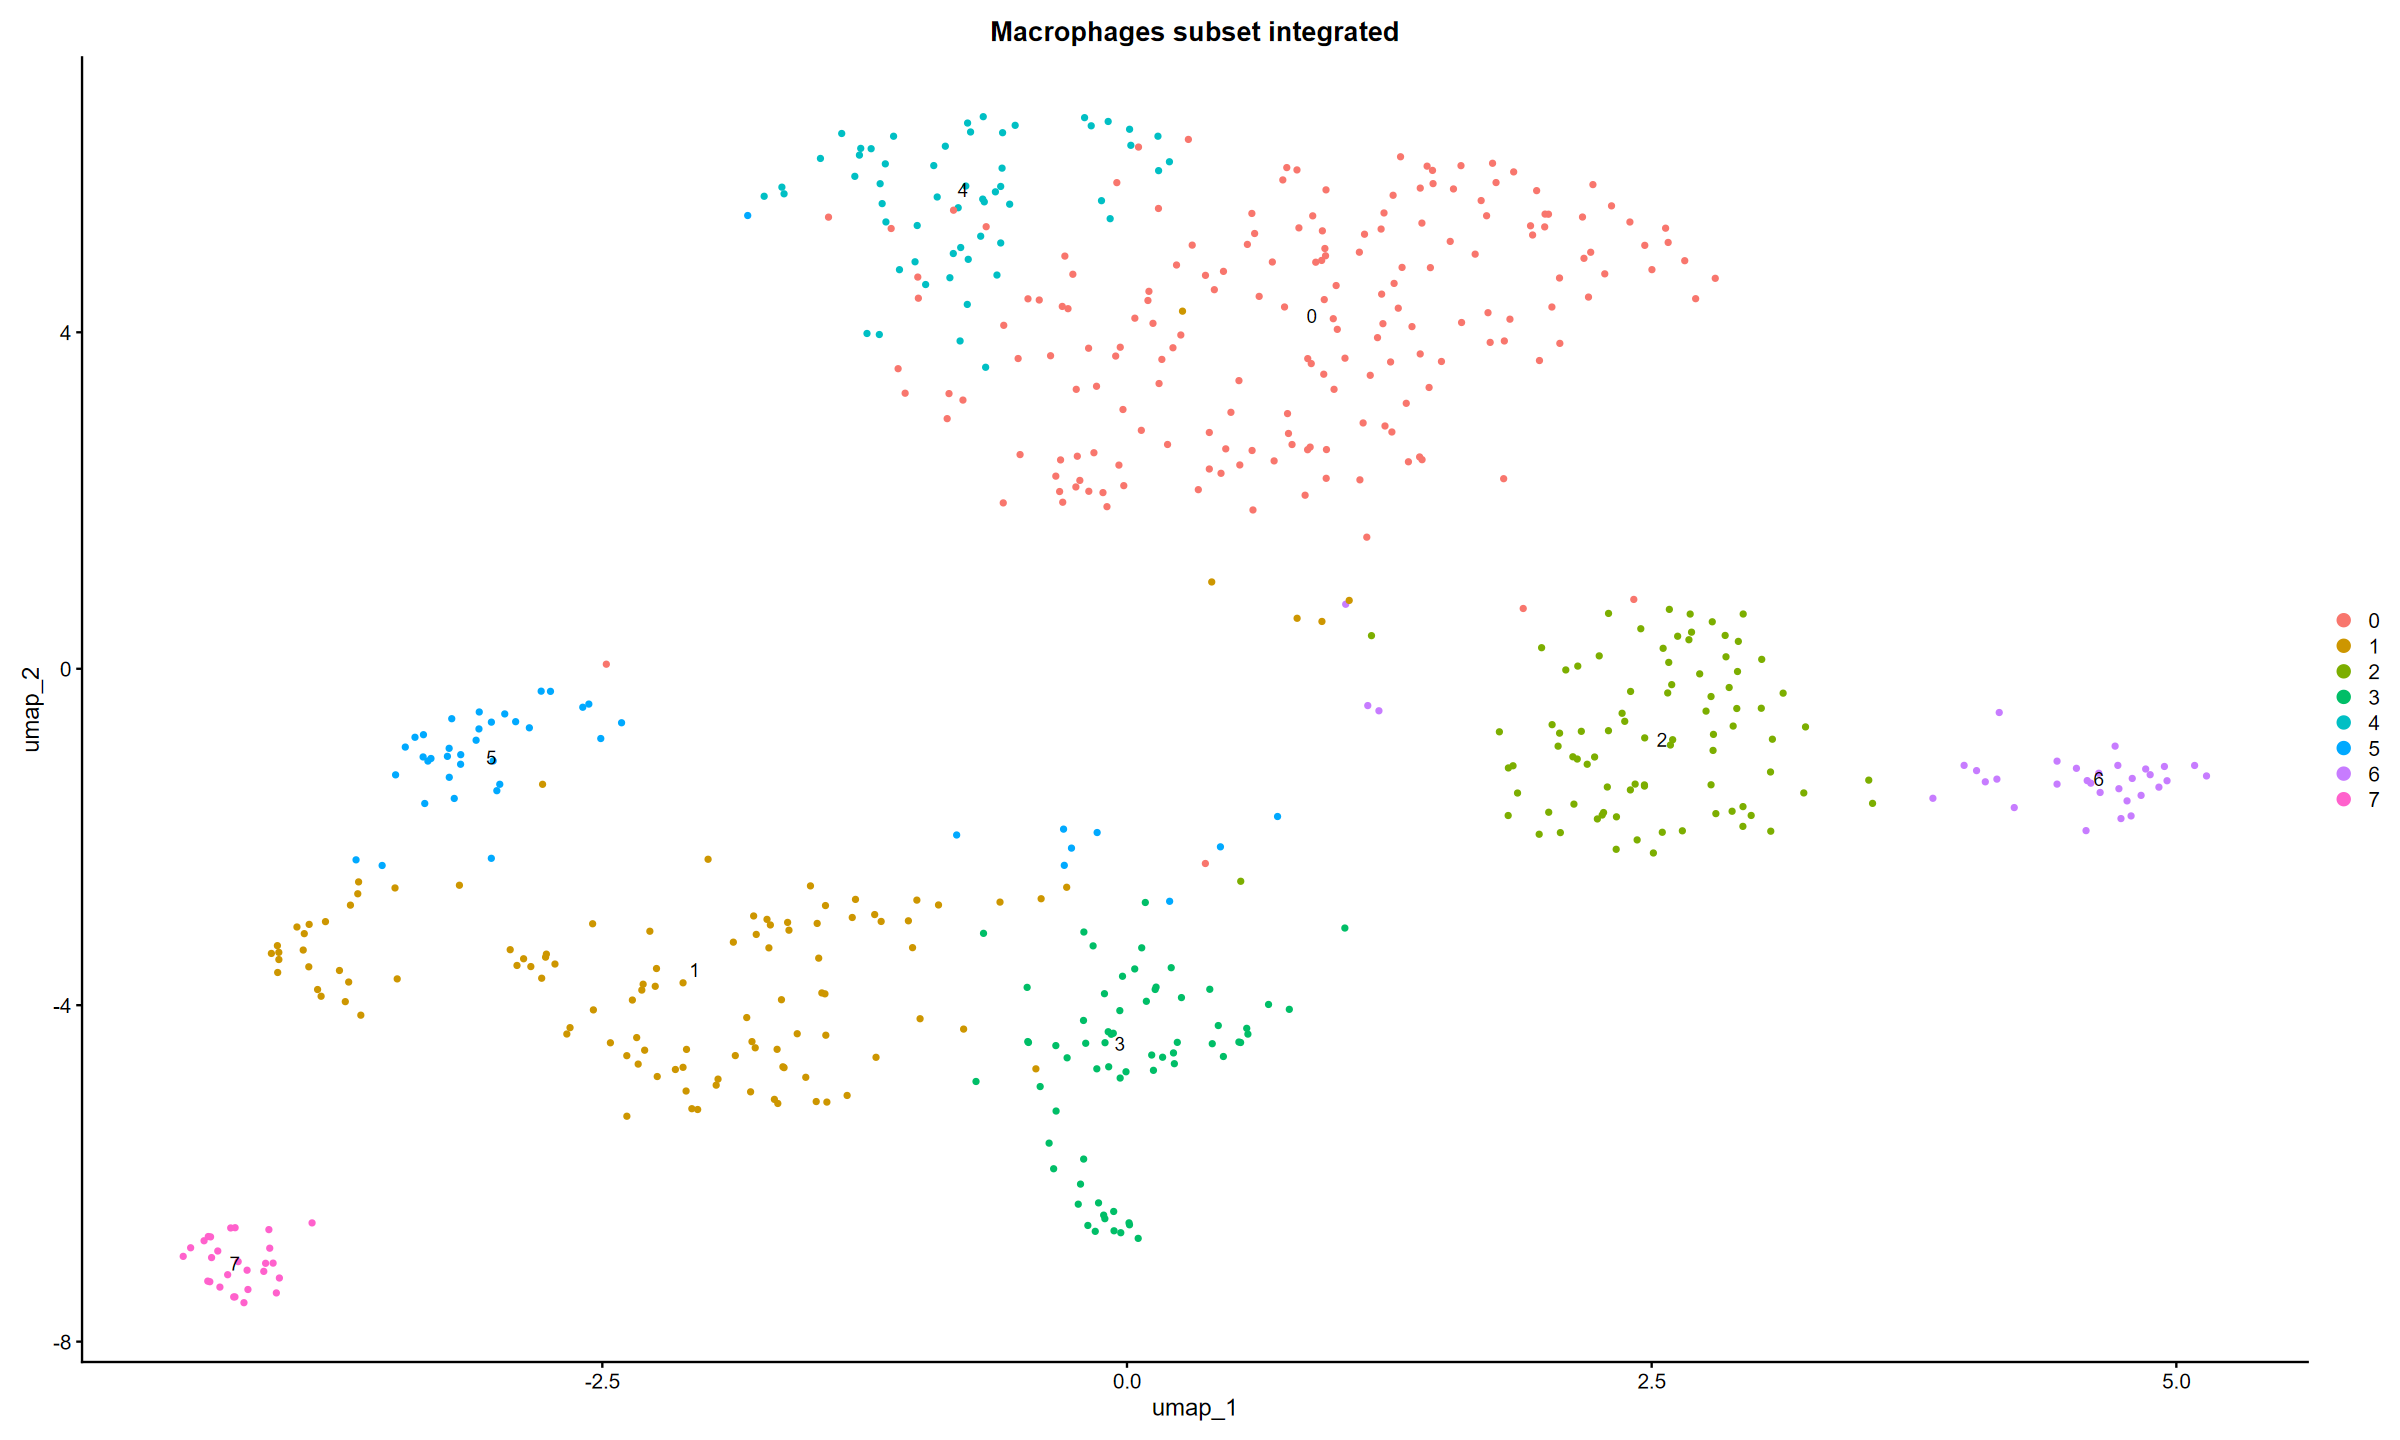

In [44]:
Idents(myeloid_data) <- "seurat_clusters"

# Plot
DimPlot(myeloid_data, reduction = "umap", group.by = "RNA_snn_res.0.8", label = TRUE) + 
    ggtitle("Macrophages subset integrated")

In [46]:
# Save myeloid_cells
saveRDS(myeloid_data, file = "Winkels_myeloid_subset.rds")